# Random Forest Analysis of Cozie Data Tier 2
- v21 mod
- running seperate rf for each room
- not grouping by room


In [30]:
import numpy as np
import pandas as pd
from datetime import datetime
import os

# Preperation
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# Visualisations
from sklearn.tree import export_graphviz # Note that you need to brew install graphviz on your local machine
import pydot 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Evaluation
from sklearn import metrics

# User Defined Functions
import cozie_functions

In [31]:
# Add Data Folder to Path
data_path = os.path.abspath(os.path.join(os.path.dirname( "__file__" ), '..', 'data'))

# Reading Data
In this case we are first reading the data, and then reorganising them into groups. 
- First drop all unecessary data
- Then drop all Sensing Data
- Then drop all mbient Data

Afterwards, created normalised datasets of the average value. See `cozie_functions.py`

In [32]:
# The following participants took part in the experiment:
participant_ids = ['cresh' + str(id).zfill(2) for id in range(1,31)]
print(participant_ids)

['cresh01', 'cresh02', 'cresh03', 'cresh04', 'cresh05', 'cresh06', 'cresh07', 'cresh08', 'cresh09', 'cresh10', 'cresh11', 'cresh12', 'cresh13', 'cresh14', 'cresh15', 'cresh16', 'cresh17', 'cresh18', 'cresh19', 'cresh20', 'cresh21', 'cresh22', 'cresh23', 'cresh24', 'cresh25', 'cresh26', 'cresh27', 'cresh28', 'cresh29', 'cresh30']


In [33]:
# Read All Data 

feature_set_df = pd.read_csv(os.path.join(data_path, '2019-10-29_cozie_full.csv'))
feature_set_df.drop(['Unnamed: 0', 'index', 'comfort_cozie', 'Space_id', 'Longitude',
                     'Latitude', 'co2_sensing', 'voc_sensing', 'Floor', 'lat_cozie', 
                     'lon_cozie', 'responseSpeed_cozie'], axis=1, inplace=True)

## Drop Mbient Data (Tier 1b)
feature_set_df.drop(["temperature_mbient"], axis=1, inplace=True)

## Drop Sensing Data (Tier 3)
feature_set_df.drop(["noise_sensing",
                    "temperature_sensing", "humidity_sensing", "light_sensing"], axis=1, inplace=True)


feature_set_df.dropna(subset=['thermal_cozie', 'heartRate_cozie', "room"], inplace=True)

# Drop User's that were trialing and not in the experiment
feature_set_df = feature_set_df[feature_set_df.user_id.isin(participant_ids)]

# Added in V3
grouped_user_df = cozie_functions.normalise_total_cozie(feature_set_df, 'user_id', 10)
grouped_user_df.drop(["thermal_cozie", "heartRate_cozie", "clothing",
                      "time", "room", "noise_cozie", "light_cozie", ], axis=1, inplace=True)

grouped_user_df.drop(["thermaly_comfy", 'aurally_comfy', 'visually_comfy'], axis=1, inplace=True)

# Added in V5
grouped_room_df = cozie_functions.normalise_total_cozie(feature_set_df, 'room', 5)
grouped_room_df.drop(["thermal_cozie", "heartRate_cozie", "clothing",
                      "time", "user_id", "noise_cozie", "light_cozie", ], axis=1, inplace=True)

grouped_room_df.drop(["thermaly_comfy", 'aurally_comfy', 'visually_comfy'], axis=1, inplace=True)



In [34]:
#feature_set_df[feature_set_df["room"] == "OPEN_EXHIBITION_SPACE_2"]




# Feature Engineering

## Clustering the data using kmeans

### Clustering by User_ID

### Combining Clusters back to feature set

- Just some pandas logic to get the groups as a feature in the feature set

In [35]:
# Extracting time for future rug plot
starting_date = pd.to_datetime("4th November, 2019")
def create_rug_df(room):
    
    rug_df = pd.DataFrame()

    room_df = feature_set_df[feature_set_df["room"] == room]

    rug_df[['time', 'thermal_cozie', 'light_cozie', 'noise_cozie']] = room_df[['time', 'thermal_cozie', 'light_cozie', 'noise_cozie']]
    rug_df["time"] = rug_df["time"].apply(pd.Timestamp).dt.tz_convert('Asia/Singapore')

    #Monday is 0, 4th November is a Monday
    rug_df["minute_of_week"] = rug_df['time'].dt.dayofweek*1440 + rug_df["time"].dt.hour * 60 + rug_df["time"].dt.minute

    rug_df["hour_of_week"] = pd.to_timedelta(rug_df['minute_of_week'], unit='m')
    rug_df["starting_date"] = starting_date

    rug_df["forcast_time"] = rug_df["starting_date"] + rug_df["hour_of_week"]
    
    return(rug_df)

irc_rug_df = create_rug_df("IRC_LIBRARY_1")
open_rug_df = create_rug_df("OPEN_EXHIBITION_SPACE_2")
sde2_rug_df = create_rug_df("BUILDING_MATERIALS_LAB")


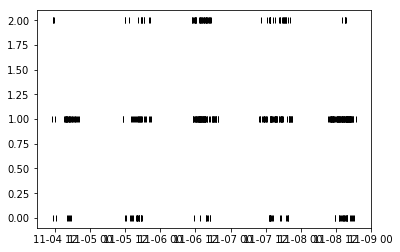

In [36]:
#sns.rugplot(irc_rug_df["forcast_time"])
fig = plt.figure()
ax4 = fig.add_subplot(111)



#irc_rug_df["thermal_cozie"] == 9

ax4.plot(irc_rug_df["forcast_time"], irc_rug_df["thermal_cozie"]-9, color='k',marker = '|', linestyle="None")  # rug plot
#ax4.plot(irc_rug_df["forcast_time"], np.zeros(irc_rug_df["forcast_time"].shape), color='r',marker = '+', ms=2, ls = "None")  # rug plot

#x_eval = np.linspace(-10, 10, num=200)
#ax4.plot(x_eval, kde1(x_eval), 'k-', label="Scott's Rule")
#ax4.plot(x_eval, kde1(x_eval), 'r-', label="Silverman's Rule")

In [37]:
irc_rug_df["forcast_time"]

156    2019-11-08 15:52:00
369    2019-11-04 15:35:00
376    2019-11-04 15:53:00
379    2019-11-04 16:09:00
383    2019-11-04 16:23:00
387    2019-11-04 16:39:00
392    2019-11-04 16:54:00
401    2019-11-04 17:08:00
409    2019-11-04 17:25:00
513    2019-11-05 11:19:00
573    2019-11-05 13:59:00
575    2019-11-05 14:08:00
586    2019-11-05 14:39:00
591    2019-11-05 14:55:00
620    2019-11-05 15:56:00
629    2019-11-05 16:17:00
639    2019-11-05 16:32:00
644    2019-11-05 16:47:00
647    2019-11-05 17:02:00
657    2019-11-05 17:17:00
680    2019-11-05 18:45:00
684    2019-11-05 19:07:00
697    2019-11-05 20:02:00
698    2019-11-05 20:02:00
703    2019-11-05 20:22:00
706    2019-11-05 20:34:00
712    2019-11-05 20:49:00
816    2019-11-06 11:11:00
830    2019-11-06 11:33:00
833    2019-11-06 11:42:00
               ...        
3602   2019-11-08 12:59:00
3605   2019-11-08 13:15:00
3609   2019-11-08 13:30:00
3612   2019-11-08 13:45:00
3615   2019-11-08 14:00:00
3619   2019-11-08 14:16:00
3

In [38]:
feature_set_df['time'] = feature_set_df['time'].apply(pd.Timestamp).dt.tz_convert('Asia/Singapore')

# get minute of the day and day of the week
feature_set_df['time_minute'] = feature_set_df['time'].dt.hour * 60 + feature_set_df['time'].dt.minute
feature_set_df['day_of_week'] = feature_set_df['time'].dt.dayofweek

# Create cyclical features for the time and day of the week
feature_set_df['hour_sin'] = np.sin(feature_set_df.time_minute * (2. * np.pi/1440)) #24*60 = 1440
feature_set_df['hour_cos'] = np.cos(feature_set_df.time_minute * (2. * np.pi/1440))

feature_set_df['day_of_week_sin'] = np.sin(feature_set_df.day_of_week * (2. * np.pi/7))
feature_set_df['day_of_week_cos'] = np.cos(feature_set_df.day_of_week * (2. * np.pi/7))

feature_set_df.drop(['time', 'time_minute', 'day_of_week'], axis=1, inplace=True)

# Let's get an overview of the features we have
feature_set_df.head()

,clothing,heartRate_cozie,light_cozie,noise_cozie,thermal_cozie,user_id,room,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
118,11.0,70.0,10.0,10.0,10.0,cresh07,BUILDING_MATERIALS_LAB,-0.342020,-0.939693,-0.433884,-0.900969
120,10.0,83.0,10.0,10.0,11.0,cresh10,BUILDING_MATERIALS_LAB,-0.346117,-0.938191,-0.433884,-0.900969
122,11.0,61.0,10.0,10.0,10.0,cresh07,BUILDING_MATERIALS_LAB,-0.382683,-0.923880,-0.433884,-0.900969
123,10.0,92.0,10.0,10.0,11.0,cresh10,BUILDING_MATERIALS_LAB,-0.382683,-0.923880,-0.433884,-0.900969
124,11.0,70.0,10.0,10.0,10.0,cresh07,BUILDING_MATERIALS_LAB,-0.465615,-0.884988,-0.433884,-0.900969


In [39]:
#Take average results and map it back to the feature_set

preferences = ['prefer_cooler', 'prefer_warmer', 'prefer_dimmer', 'prefer_brighter','prefer_quieter', 'prefer_louder']

for preference in preferences:
    map_dict = grouped_user_df[preference].to_dict()
    label = "user_grouped_" + preference.split("_")[1]
    feature_set_df[label] = feature_set_df['user_id'].map(map_dict)

#Deleted the room mapping 

# Do this by first creating a dictionary, and then running the .map method

feature_set_df.dropna(subset=["user_grouped_cooler", "user_grouped_warmer"], inplace=True)
#

In [40]:
open_feature_set_df = feature_set_df[feature_set_df["room"] == "OPEN_EXHIBITION_SPACE_2"]

In [41]:
irc_feature_set_df = feature_set_df[feature_set_df["room"] == "IRC_LIBRARY_1"]

In [42]:
sde2_feature_set_df = feature_set_df[feature_set_df["room"] == "BUILDING_MATERIALS_LAB"]

In [43]:
feature_set_df.drop(["user_id", "room"], axis=1, inplace=True)

### Extracting time as a feature and converting it to polar coordinate

- As time (such as hour in a day, or day in a week) is not a linear metric, it is important to convert it to polar coordinates
- http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

In [44]:
print(open_feature_set_df.shape)
print(irc_feature_set_df.shape)
print(sde2_feature_set_df.shape)

(140, 17)
(424, 17)
(195, 17)


In [45]:
# Let's get a statistical overview of the features we have
feature_set_df.columns

Index(['clothing', 'heartRate_cozie', 'light_cozie', 'noise_cozie',
       'thermal_cozie', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'user_grouped_cooler', 'user_grouped_warmer',
       'user_grouped_dimmer', 'user_grouped_brighter', 'user_grouped_quieter',
       'user_grouped_louder'],
      dtype='object')

### Hot Encoding Catergorical Features
- Here is a great explanation on why this is important https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In [46]:
# Convert Rooms and user Id to binary inputs (Hot Encoding)
## Modified in V3, and V5

#feature_set_df = pd.get_dummies(feature_set_df, columns=['room_cluster', 'user_cluster'])
#print(list(feature_set_df.columns))

In [47]:
# Check if our feature set has any NaN's
print(feature_set_df.shape)
print(feature_set_df.dropna().shape)
print(feature_set_df.columns)

(1516, 15)
(1455, 15)
Index(['clothing', 'heartRate_cozie', 'light_cozie', 'noise_cozie',
       'thermal_cozie', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'user_grouped_cooler', 'user_grouped_warmer',
       'user_grouped_dimmer', 'user_grouped_brighter', 'user_grouped_quieter',
       'user_grouped_louder'],
      dtype='object')


### Split Training and Testing Data
- currently splitting to a 4:1 train:test split

In [48]:
thermal_feature_list = ['clothing', 'heartRate_cozie', 'hour_sin', 'hour_cos', 
'day_of_week_sin', 'day_of_week_cos', 'user_grouped_cooler', 'user_grouped_warmer']

noise_feature_list = ['clothing', 'heartRate_cozie', 'hour_sin', 'hour_cos', 
'day_of_week_sin', 'day_of_week_cos', 'user_grouped_quieter', 'user_grouped_louder']

light_feature_list = ['clothing', 'heartRate_cozie', 'hour_sin', 'hour_cos', 
'day_of_week_sin', 'day_of_week_cos', 'user_grouped_dimmer', 'user_grouped_brighter']

def prepare_room_data(dataframe):

    
    thermal_test_train = create_training_data(dataframe, preference="thermal", feature_list = thermal_feature_list)
    #thermal_train_features, thermal_test_features, thermal_train_labels, thermal_test_labels = thermal_test_train

    light_test_train = create_training_data(dataframe, preference="light", feature_list = light_feature_list)
    #light_train_features, light_test_features, light_train_labels, light_test_labels = light_test_train

    
    noise_test_train = create_training_data(dataframe, preference="noise", feature_list = noise_feature_list)
    #noise_train_features, noise_test_features, noise_train_labels, noise_test_labels = noise_test_train


    return(thermal_test_train, light_test_train, noise_test_train)
    
def create_training_data(dataframe, preference, feature_list):
    clean_dataframe = dataframe.copy(deep=True)
    clean_dataframe.dropna(subset = [preference + '_cozie'], inplace = True)
    
    labels = np.array(clean_dataframe[preference + '_cozie'])

    features_df = clean_dataframe[feature_list]
    print(features_df.columns)
    feature_set = np.array(features_df)
    
    train_features, test_features, train_labels, test_labels = train_test_split(feature_set, 
        labels, 
        test_size = 0.25, 
        random_state = 42)

    
    return(train_features, test_features, train_labels, test_labels)
# thermal_train_features, thermal_test_features, thermal_train_labels, thermal_test_labels


irc_data = prepare_room_data(irc_feature_set_df)

open_data = prepare_room_data(open_feature_set_df)

sde2_data = prepare_room_data(sde2_feature_set_df)



Index(['clothing', 'heartRate_cozie', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'user_grouped_cooler',
       'user_grouped_warmer'],
      dtype='object')
Index(['clothing', 'heartRate_cozie', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'user_grouped_dimmer',
       'user_grouped_brighter'],
      dtype='object')
Index(['clothing', 'heartRate_cozie', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'user_grouped_quieter',
       'user_grouped_louder'],
      dtype='object')
Index(['clothing', 'heartRate_cozie', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'user_grouped_cooler',
       'user_grouped_warmer'],
      dtype='object')
Index(['clothing', 'heartRate_cozie', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'user_grouped_dimmer',
       'user_grouped_brighter'],
      dtype='object')
Index(['clothing', 'heartRate_cozie', 'hour_sin', 'hour_cos',
       'day_of_wee

In [49]:
def print_data_shape(data):
    thermal_train_features, thermal_test_features, thermal_train_labels, thermal_test_labels = data[0]
    light_train_features, light_test_features, light_train_labels, light_test_labels = data[1]
    noise_train_features, noise_test_features, noise_train_labels, noise_test_labels = data[2]
    print('Thermal Training Features Shape:', thermal_train_features.shape)
    print('Thermal Training Labels Shape:', thermal_train_labels.shape)
    print('Thermal Testing Features Shape:', thermal_test_features.shape)
    print('Thermal Testing Labels Shape:', thermal_test_labels.shape)
    print('')
    print('Noise Training Features Shape:', noise_train_features.shape)
    print('Noise Training Labels Shape:', noise_train_labels.shape)
    print('Noise Testing Features Shape:', noise_test_features.shape)
    print('Noise Testing Labels Shape:', noise_test_labels.shape)
    print('')
    print('Light Training Features Shape:', light_train_features.shape)
    print('Light Training Labels Shape:', light_train_labels.shape)
    print('Light Testing Features Shape:', light_test_features.shape)
    print('Light Testing Labels Shape:', light_test_labels.shape)
print("IRC Data shape is")
print_data_shape(irc_data)

print("open exhubition space Data shape is")
print_data_shape(open_data)

print("SDE2 bml Data shape is")
print_data_shape(sde2_data)

IRC Data shape is
Thermal Training Features Shape: (318, 8)
Thermal Training Labels Shape: (318,)
Thermal Testing Features Shape: (106, 8)
Thermal Testing Labels Shape: (106,)

Noise Training Features Shape: (294, 8)
Noise Training Labels Shape: (294,)
Noise Testing Features Shape: (98, 8)
Noise Testing Labels Shape: (98,)

Light Training Features Shape: (318, 8)
Light Training Labels Shape: (318,)
Light Testing Features Shape: (106, 8)
Light Testing Labels Shape: (106,)
open exhubition space Data shape is
Thermal Training Features Shape: (105, 8)
Thermal Training Labels Shape: (105,)
Thermal Testing Features Shape: (35, 8)
Thermal Testing Labels Shape: (35,)

Noise Training Features Shape: (104, 8)
Noise Training Labels Shape: (104,)
Noise Testing Features Shape: (35, 8)
Noise Testing Labels Shape: (35,)

Light Training Features Shape: (105, 8)
Light Training Labels Shape: (105,)
Light Testing Features Shape: (35, 8)
Light Testing Labels Shape: (35,)
SDE2 bml Data shape is
Thermal Tra

# Modeling Using Random Forests
- Nothing too fancy here

In [50]:

def build_rf(data):
    thermal_train_features, thermal_test_features, thermal_train_labels, thermal_test_labels = data[0]
    light_train_features, light_test_features, light_train_labels, light_test_labels = data[1]
    noise_train_features, noise_test_features, noise_train_labels, noise_test_labels = data[2]
    
    # Instantiate model with 1000 decision trees
    thermal_rf = RandomForestClassifier(n_estimators = 1000, random_state = 42 )
    # Train the model on training data
    thermal_rf.fit(thermal_train_features, thermal_train_labels);
    # Use the forest's predict method on the test data
    thermal_predictions = thermal_rf.predict(thermal_test_features)
    
    # Instantiate model with 1000 decision trees
    light_rf = RandomForestClassifier(n_estimators = 1000, random_state = 42 )
    # Train the model on training data
    light_rf.fit(light_train_features, light_train_labels);
    # Use the forest's predict method on the test data
    light_predictions = light_rf.predict(light_test_features)

    # Instantiate model with 1000 decision trees
    noise_rf = RandomForestClassifier(n_estimators = 1000, random_state = 42 )
    # Train the model on training data
    noise_rf.fit(noise_train_features, noise_train_labels);
    # Use the forest's predict method on the test data
    noise_predictions = noise_rf.predict(noise_test_features)


    return({"forests": {"thermal": thermal_rf, "light": light_rf, "noise": noise_rf},
           "predictions": {"thermal": thermal_predictions, "light": light_predictions,
                           "noise": noise_predictions}})

In [51]:

irc_forest = build_rf(irc_data)
open_forest = build_rf(open_data)
sde2_forest = build_rf(sde2_data)

In [52]:
irc_forest

{'forests': {'thermal': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False),
  'light': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False),
  'noise': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, ma

## Calculate the Error Rate

In [53]:
def list_feature_importance(rf, feature_list):
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    print("")

    
def prediction_accuracy_report(data, forest):
    # Unpack the test train data
    thermal_train_features, thermal_test_features, thermal_train_labels, thermal_test_labels = data[0]
    light_train_features, light_test_features, light_train_labels, light_test_labels = data[1]
    noise_train_features, noise_test_features, noise_train_labels, noise_test_labels = data[2] 
    
    thermal_predictions = forest["predictions"]["thermal"]
    light_predictions = forest["predictions"]["light"]
    noise_predictions = forest["predictions"]["noise"]
    
    print("Summary of Thermal Prediction")
    print(metrics.accuracy_score(thermal_predictions, thermal_test_labels))
    print(metrics.f1_score(thermal_predictions, thermal_test_labels, average="micro")) # Micro averages all the results
    print(metrics.f1_score(thermal_predictions, thermal_test_labels, average="macro")) #Macro treats each class equally 
    print(metrics.confusion_matrix(thermal_predictions,thermal_test_labels))
    print(metrics.classification_report(thermal_predictions,thermal_test_labels))

    print("Summary of Light Prediction")
    print(metrics.accuracy_score(light_predictions, light_test_labels))
    print(metrics.f1_score(light_predictions, light_test_labels, average="micro")) # Micro averages all the results
    print(metrics.f1_score(light_predictions, light_test_labels, average="macro")) #Macro treats each class equally 
    print(metrics.confusion_matrix(light_predictions,light_test_labels))
    print(metrics.classification_report(light_predictions,light_test_labels))

    print("Summary of Noise Prediction")
    print(metrics.accuracy_score(noise_predictions, noise_test_labels))
    print(metrics.f1_score(noise_predictions, noise_test_labels, average="micro")) # Micro averages all the results
    print(metrics.f1_score(noise_predictions, noise_test_labels, average="macro")) #Macro treats each class equally 
    print(metrics.confusion_matrix(noise_predictions,noise_test_labels))
    print(metrics.classification_report(noise_predictions,noise_test_labels))

    list_feature_importance(rf = forest["forests"]["thermal"], feature_list=thermal_feature_list)
    list_feature_importance(rf = forest["forests"]["light"], feature_list=light_feature_list)
    list_feature_importance(rf = forest["forests"]["noise"], feature_list=noise_feature_list)


In [54]:
prediction_accuracy_report(sde2_data,sde2_forest)


Summary of Thermal Prediction
0.6122448979591837
0.6122448979591837
0.5953042328042328
[[11  1  1]
 [ 7 14  6]
 [ 1  3  5]]
              precision    recall  f1-score   support

         9.0       0.58      0.85      0.69        13
        10.0       0.78      0.52      0.62        27
        11.0       0.42      0.56      0.48         9

   micro avg       0.61      0.61      0.61        49
   macro avg       0.59      0.64      0.60        49
weighted avg       0.66      0.61      0.61        49

Summary of Light Prediction
0.8775510204081632
0.8775510204081631
0.5317460317460317
[[ 4  1  0]
 [ 3 39  2]
 [ 0  0  0]]
              precision    recall  f1-score   support

         9.0       0.57      0.80      0.67         5
        10.0       0.97      0.89      0.93        44
        11.0       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        49
   macro avg       0.52      0.56      0.53        49
weighted avg       0.93      0.88      0.90    

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Forcasting

## Create dummy time series data to visualise how the model works

In [55]:
starting_date

Timestamp('2019-11-04 00:00:00')

In [56]:
forcast_df = pd.DataFrame(starting_date + pd.to_timedelta(np.arange(24*7), 'h'), columns = ["time"])

In [57]:
forcast_df['time'].apply(pd.Timestamp)
print(2)

2


['clothing', 'heartRate_cozie', 'light_cozie', 'noise_cozie',
       'thermal_cozie', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'user_grouped_cooler', 'user_grouped_warmer',
       'user_grouped_dimmer', 'user_grouped_brighter', 'user_grouped_quieter',
       'user_grouped_louder', 'room_grouped_cooler', 'room_grouped_warmer',
       'room_grouped_dimmer', 'room_grouped_brighter', 'room_grouped_quieter',
       'room_grouped_louder'],

In [58]:

forcast_df['clothing'] = 9
forcast_df['heartRate_cozie'] = 70


In [59]:
# get minute of the day and day of the week
forcast_df['time_minute'] = forcast_df['time'].dt.hour * 60 + forcast_df['time'].dt.minute
forcast_df['day_of_week'] = forcast_df['time'].dt.dayofweek

# Create cyclical features for the time and day of the week
forcast_df['hour_sin'] = np.sin(forcast_df.time_minute * (2. * np.pi/1440)) #24*60 = 1440
forcast_df['hour_cos'] = np.cos(forcast_df.time_minute * (2. * np.pi/1440))

forcast_df['day_of_week_sin'] = np.sin(forcast_df.day_of_week * (2. * np.pi/7))
forcast_df['day_of_week_cos'] = np.cos(forcast_df.day_of_week * (2. * np.pi/7))

forcast_time = np.array(forcast_df['time']) #for plotting later

forcast_df.drop(['time', 'time_minute', 'day_of_week'], axis=1, inplace=True)


In [60]:
forcast_df.columns

Index(['clothing', 'heartRate_cozie', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [61]:
reset_forcast_df = forcast_df.copy(deep=True)

In [62]:
#rooms_forcasted = ['IRC_LIBRARY_1', 'OPEN_EXHIBITION_SPACE_2', 'BUILDING']
preferences_forcasted = ['thermal', 'light', 'noise']
preference_map = {'thermal': ['cooler', 'warmer'], 'light': ['dimmer', 'brighter'], 'noise': ['quieter', 'louder']}
#rf_map = {'thermal': thermal_rf, 'light': light_rf, 'noise': noise_rf}

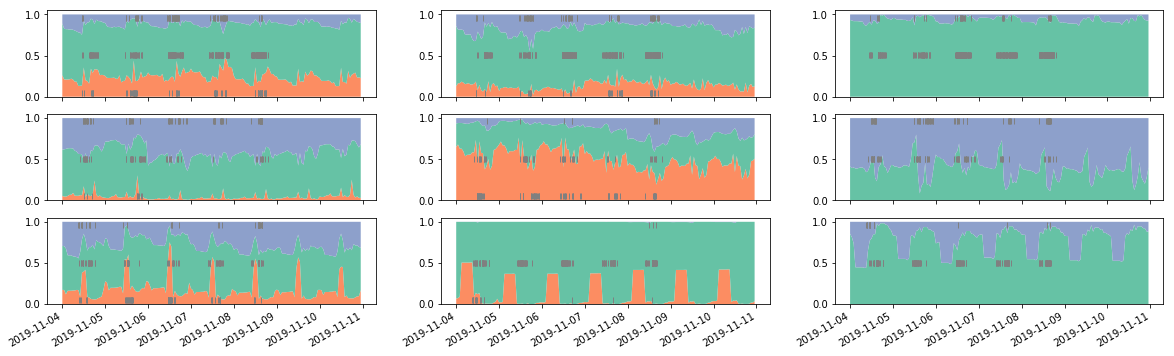

In [63]:
# Prepare palette
palette = sns.color_palette("Set2", 3)
pal = [palette[1],palette[0],palette[2]]

fig1, axes = plt.subplots(3, 3, figsize=(20, 6))



#for ii, room in enumerate(rooms_forcasted):
def forcast_room_plot(dataframe, forest, rug_df, plot_row):
    # Loop through preferences forcasted
    for jj, preference in enumerate(preferences_forcasted):
        forcast_df = reset_forcast_df.copy(deep=True)
        # loop through the labels to set features
        for label in preference_map[preference]:
            # eg: 'user_grouped_warmer'
            forcast_df['user_grouped_' + label] = dataframe.describe().loc['mean']['user_grouped_' + label]

            
        # Convert to np array
        forcast_features = np.array(forcast_df)
        

        comfort_probability = forest["forests"][preference].predict_proba(forcast_features)
        
        if comfort_probability.shape[1] == 2:
            pal = [palette[0],palette[2],palette[2]]
        else:
            pal = [palette[1],palette[0],palette[2]]

         
            
            
            
        axes[plot_row,jj].stackplot(forcast_time, np.transpose(comfort_probability), colors = pal, alpha = 1)
        axes[plot_row, jj].plot(rug_df["forcast_time"], (rug_df[preference + "_cozie"]-9)/2.2 + 0.05, color='gray',marker = '|', linestyle="None")  # rug plot
        #axes[plot_row,jj].xaxis.set_minor_locator(plt.MaxNLocator(4))
        #axes[plot_row,jj].xaxis.set_minor_locator(mdates.WeekdayLocator(5))
        
        axes[plot_row,jj].xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
        plt.gcf().autofmt_xdate()
        #plt.legend()
            
forcast_room_plot(irc_feature_set_df, forest = irc_forest, rug_df = irc_rug_df, plot_row=0)  
forcast_room_plot(open_feature_set_df, forest = open_forest, rug_df = open_rug_df, plot_row=1) 
forcast_room_plot(sde2_feature_set_df, forest = sde2_forest, rug_df = sde2_rug_df, plot_row=2) 

plt.savefig("comfort_prediction.pdf")

In [64]:
irc

NameError: name 'irc' is not defined